# Blood Glucose Control - EDA

**Name:** Vilohith Rao 



### Import Data

There are multiple data sets each corresponding to a person with diabetes. Please load the files into a single data set while retaining the ability to distinguish between the PWD. 

In [4]:
import pandas as pd
import os

# get all csv files in the 'data' directory
# data_dir = 'data'
data_dir = os.path.join(os.getcwd(), '../', 'data')
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# array to store the dfs
dfs = []

# read each csv and add a PWD id by the files last digits
for i, file in enumerate(csv_files):
    df = pd.read_csv(os.path.join(data_dir, file))
    # get the numbers in the file name
    file_digits_id = file.split("_")[-1].split(".")[0]
    # new pwd id
    df['PWD_ID'] = file_digits_id  
    dfs.append(df)

# combine all separate pwd to a single df
combined_df = pd.concat(dfs, ignore_index=True)

# first few rows and general statistics
print(combined_df.columns)
combined_df.head()
# print(combined_df.head())
# print(combined_df.info())

Index(['date', 'sender_id', 'bgl', 'bgl_date_millis', 'text', 'template',
       'msg_type', 'affects_fob', 'affects_iob', 'dose_units', 'food_g',
       'food_glycemic_index', 'dose_automatic', 'fp_bgl',
       'message_basal_change', '__typename', 'trend', 'PWD_ID'],
      dtype='object')


,date,sender_id,bgl,bgl_date_millis,text,template,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index,dose_automatic,fp_bgl,message_basal_change,__typename,trend,PWD_ID
0,2024-05-01 00:00:27.029000-05:00,NaN,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030
1,2024-05-01 00:05:27.183000-05:00,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030
2,2024-05-01 00:10:26.949000-05:00,NaN,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030
3,2024-05-01 00:15:27.180000-05:00,NaN,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030
4,2024-05-01 00:20:27.021000-05:00,NaN,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030


In [8]:
print(combined_df["msg_type"].unique())

[nan 'DOSE_INSULIN' 'ANNOUNCE_MEAL' 'INTERVENTION_SNACK'
 'DOSE_BASAL_INSULIN' 'BGL_FP_READING_CGM_CALIBRATION' 'NEW_TRANSMITTER'
 'NEW_SENSOR' 'ANNOUNCE_EXERCISE' 'TEXT' 'BGL_FP_READING' 'DOSE_MEDICINE'
 'NEW_PEN' 'BADGE' 'MEDICAL_TEST_RESULT']


### Two Data Visualizations

Create at least two visualizations that are of interest to you. They can be things that would be useful information for a PWD to know, or they could be useful for informing future modeling work. If you aren't sure what to visualize try recreating common diabetes data visualizations that you can find on the internet. 

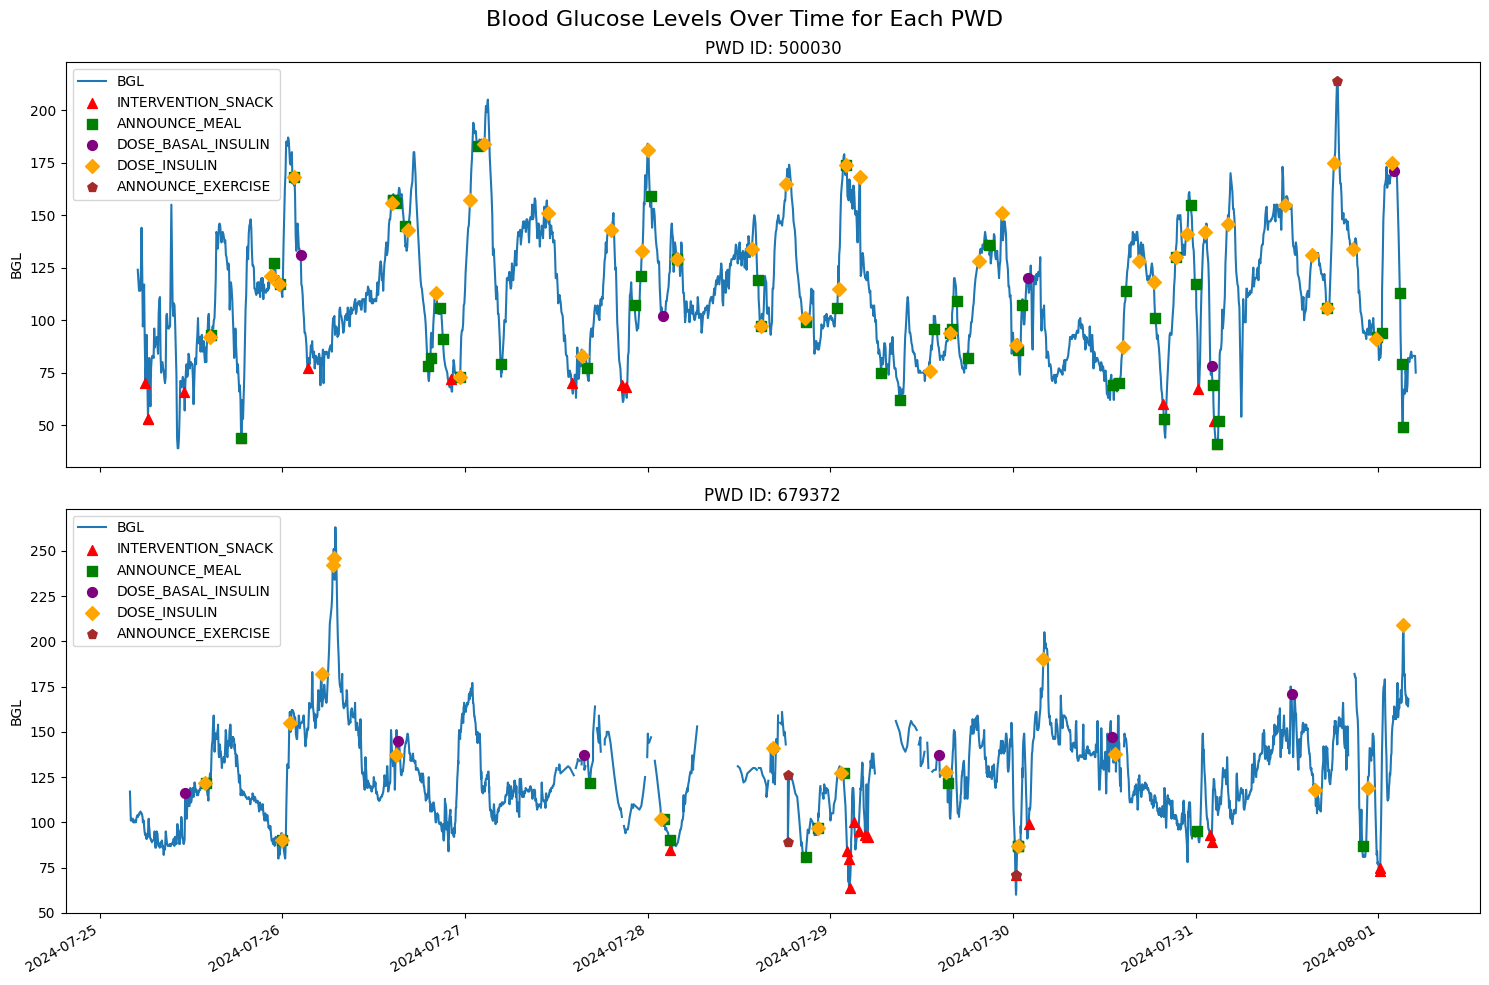

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import pandas as pd

# constants
TIMEFRAME_DAYS = 7  # number of days to display in the plot
# some events that are relevant (these events will be marked on the plot)
RELEVANT_MSG_TYPES = ["INTERVENTION_SNACK", "ANNOUNCE_MEAL", "DOSE_BASAL_INSULIN", "DOSE_INSULIN", "ANNOUNCE_EXERCISE", "DOSE_MEDICINE"]
# the markers associated with each event
MARKERS = {
    "INTERVENTION_SNACK": "^",
    "ANNOUNCE_MEAL": "s",
    "DOSE_BASAL_INSULIN": "o",
    "DOSE_INSULIN": "D",
    "ANNOUNCE_EXERCISE": "p",
    "DOSE_MEDICINE": "*"
}
# the colors associated with each marker
COLORS = {
    "INTERVENTION_SNACK": "red",
    "ANNOUNCE_MEAL": "green",
    "DOSE_BASAL_INSULIN": "purple",
    "DOSE_INSULIN": "orange",
    "ANNOUNCE_EXERCISE": "brown",
    "DOSE_MEDICINE": "pink"
}

def prepare_data(combined_df):
    """
    Prepare the data for plotting.
    ---
    1. Converts the date column to pd datetime format
    """
    combined_df['date'] = pd.to_datetime(combined_df['date'], format='mixed', utc=True)
    return combined_df

def plot_event_markers(ax, pwd_data):
    """Plot markers for relevant events."""
    for msg_type in RELEVANT_MSG_TYPES:
        events = pwd_data[pwd_data['msg_type'] == msg_type]
        if not events.empty:
            ax.scatter(events['date'], events['bgl'], 
                       marker=MARKERS[msg_type], s=50, label=msg_type, color=COLORS[msg_type], zorder=2)

def plot_pwd_data(ax, pwd_data, pwd_id):
    """Plot data for a single PWD."""
    end_date = pwd_data['date'].max()
    start_date = end_date - pd.Timedelta(days=TIMEFRAME_DAYS)
    pwd_data_filtered = pwd_data[(pwd_data['date'] >= start_date) & (pwd_data['date'] <= end_date)]
    
    ax.plot(pwd_data_filtered['date'], pwd_data_filtered['bgl'], label='BGL', zorder=1)
    plot_event_markers(ax, pwd_data_filtered)
    
    ax.set_ylabel('BGL')
    ax.set_title(f'PWD ID: {pwd_id}')
    ax.legend()
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

def create_plot(combined_df):
    """Create the main plot."""
    pwd_ids = combined_df['PWD_ID'].unique()
    fig, axes = plt.subplots(len(pwd_ids), 1, figsize=(15, 5*len(pwd_ids)), sharex=True)
    fig.suptitle('Blood Glucose Levels Over Time for Each PWD', fontsize=16)
    
    for i, pwd_id in enumerate(pwd_ids):
        pwd_data = combined_df[combined_df['PWD_ID'] == pwd_id]
        plot_pwd_data(axes[i] if len(pwd_ids) > 1 else axes, pwd_data, pwd_id)
    
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

# Main execution
combined_df = prepare_data(combined_df)
create_plot(combined_df)


### Ask a question(s) about the data and/or diabetes!
When creating the visualizations you probably had some questions about managing T1D. Ask some questions that might interest you and our diabetes experts will do their best to answer them for you! *Consider this an AMAA about diabetes.* 

1. An individual with T1D will not be able to produce insulin effectively. So while managing T1D, is there more emphasis placed on meal timings (i.e when you *should* eat your meals), or the post-meal insulin dosage? 
2. Based on the plot, it seems as though the insulin dosage timings vary quite a lot. From my understanding, having a meal will increase BGL; this is when insulin could be dosed to reduce BGL. How are the timings of insulin dosage determined? Would this depend on the meal size (eg: thanksgiving dinner vs an average dinner)? 

### Final Task

Thanks for showing interest in our project! We plan to incorporate the best/most interesting visualizations into a substack post in the future. 

Please remember to create a pull request with your updated template, don't forget to rename the file to something that we can identify you with, e.g: `eda_[your_name].ipynb`